In [41]:
import torch
import torch.nn as nn                 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from model.ViT import ViT, HopfieldViT
from model import *
# Define the Vision Transformer model

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt 
# auto reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

    
# Define the Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim, dim, num_heads, img_size, patch_size, in_channels=3):
        super(VisionTransformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.hopfield = KHopfield(N=dim, n=embed_dim * self.num_patches)
        self.fc = nn.Linear(embed_dim * self.num_patches, num_classes)
        self.num_heads = num_heads

    def forward(self, x):
        x1 = self.patch_embedding(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
        x2 = x1.permute(0, 2, 3, 1)  # (batch_size, num_patches_h, num_patches_w, embed_dim)
        x3 = x2.reshape(x2.size(0), -1, x2.size(-1))  # (batch_size, num_patches, embed_dim)
        
        x4 = x3 + self.positional_embedding  # Add positional embedding
        # combine second and third dimension
        x5 = x4.flatten(1, 2)
        x6 = self.hopfield(x5, self.num_heads)
        x7 = x6.mean(dim=2)  # Global average pooling
        x8 = self.fc(x7)
        return x8
    
    def to(self, device):
        super(VisionTransformer, self).to(device)
        self.hopfield = self.hopfield.to(device)
        return self
    
# Uses #num_heads k=1 hopfield networks, rather than k=num_heads-hopfield networks
class VisionTransformerV(nn.Module):
    def __init__(self, num_classes, embed_dim, dim, num_heads, img_size, patch_size, in_channels=3):
        super(VisionTransformerV, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        self.hopfields = nn.ModuleList([KHopfield(N=dim, n=embed_dim * self.num_patches) for _ in range(num_heads)])
        self.fc = nn.Linear(embed_dim * self.num_patches, num_classes)
        self.num_heads = num_heads

    def forward(self, x):
        x1 = self.patch_embedding(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
        x2 = x1.permute(0, 2, 3, 1)  # (batch_size, num_patches_h, num_patches_w, embed_dim)
        x3 = x2.reshape(x2.size(0), -1, x2.size(-1))  # (batch_size, num_patches, embed_dim)
        
        x4 = x3 + self.positional_embedding  # Add positional embedding
        # combine second and third dimension
        x5 = x4.flatten(1, 2)
        x6 = [self.hopfields[i](x5, 1) for i in range(self.num_heads)]
        # take average of all heads
        x6 = torch.stack(x6, dim=2).squeeze()
        x7 = x6.mean(dim=2)  # Global average pooling
        x8 = self.fc(x7)
        return x8
    


In [3]:
# # Define the Vision Transformer model
# class VisionTransformer(nn.Module):
#     def __init__(self, num_classes, embed_dim, num_heads, num_layers, img_size, patch_size):
#         super(VisionTransformer, self).__init__()
#         num_patches = (img_size // patch_size) ** 2
#         self.patch_embedding = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
#         self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
#         self.transformer = nn.Transformer(
#             d_model=embed_dim,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             dim_feedforward=2048,
#             dropout=0.1,
#         )
#         self.fc = nn.Linear(embed_dim, num_classes)

#     def forward(self, x):
#         x = self.patch_embedding(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
#         x = x.permute(0, 2, 3, 1)  # (batch_size, num_patches_h, num_patches_w, embed_dim)
#         x = x.reshape(x.size(0), -1, x.size(-1))  # (batch_size, num_patches, embed_dim)
#         x = torch.cat([self.positional_embedding, x], dim=1)
#         x = self.transformer(x)
#         x = x.mean(dim=1)  # Global average pooling
#         x = self.fc(x)
#         return x


In [70]:
# Hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 1e-3
num_classes = 10
img_size = 32  # Assuming CIFAR-10 image size

#mnist

patch_size = 16  # Adjust this based on your preference

datast = 'mnist'
dataset = 'cifar'
num_heads = 4

if dataset == 'mnist':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = torchvision.datasets.MNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(root='~/data', train=False, transform=transforms.ToTensor(), download=True)
    img_size = 28
    in_channels = 1
    num_classes = 10
else:
    train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                    transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()])

    val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    train_dataset = torchvision.datasets.CIFAR10(root='~/data', train=True, transform=train_transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='~/data', train=False, transform=val_transform, download=True)
    img_size = 32
    in_channels = 3
    num_classes = 10

# Data preprocessing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize the model and optimizer
model = VisionTransformer(
    num_classes = num_classes, 
    embed_dim = 256, 
    dim  = 1024,
    num_heads = num_heads, 
    img_size = img_size, 
    patch_size = patch_size, 
    in_channels = in_channels,
)
modelV= VisionTransformerV(
    num_classes = num_classes, 
    embed_dim = 256, 
    dim  = 1024,
    num_heads = num_heads, 
    img_size = img_size, 
    patch_size = patch_size, 
    in_channels = in_channels,
)

embedding_dim = 2196
num_heads = 8
num_layers = 1
patch_size = 16

modelS = SimpleViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = 128,
    depth = 2,
    heads = 4,
    mlp_dim = 512
)

patch_size= 4
modelViT = ViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = 128,
    depth = 2,
    heads = 4,
    mlp_dim = 512
)


patch_size= 4
modelViT = ViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = 128,
    depth = 2,
    heads = 5,
    mlp_dim = 512
)

modelHViT = HopfieldViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = 128,
    depth = 2,
    heads = 5,
    mlp_dim = 512
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
modelV = modelV.to(device)
print(device)






Files already downloaded and verified
Files already downloaded and verified
cuda:3


In [43]:
image, label = next(iter(train_loader))

In [80]:
modelViT(image).shape

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        ...,

     

torch.Size([256, 10])

In [92]:
modelHViT(image).shape

torch.Size([16640, 65])
torch.Size([16640, 65])
sum of last_ssm tensor(0., grad_fn=<SumBackward0>)
sum of last_ssm tensor([65., 65., 65.,  ..., 65., 65., 65.], grad_fn=<SumBackward1>)
sum of last_ssm tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SumBackward1>)
sum of last_ssm tensor([65., 65., 65.,  ..., 65., 65., 65.], grad_fn=<SumBackward1>)
sum of last_ssm tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SumBackward1>)
torch.Size([16640, 65, 5])
tensor([[  0.,  65., -65.,  65., -65.],
        [  0.,  65., -65.,  65., -65.],
        [  0.,  65., -65.,  65., -65.],
        ...,
        [  0.,  65., -65.,  65., -65.],
        [  0.,  65., -65.,  65., -65.],
        [  0.,  65., -65.,  65., -65.]], grad_fn=<SumBackward1>)
torch.Size([16640, 65])
torch.Size([16640, 65])
sum of last_ssm tensor(0., grad_fn=<SumBackward0>)
sum of last_ssm tensor([65., 65., 65.,  ..., 65., 65., 65.], grad_fn=<SumBackward1>)
sum of last_ssm tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SumBackward1>)
sum o

torch.Size([256, 10])

In [98]:
x = torch.randn(256, 5)
print(x.shape)
result = LML2(N = 5, n_iter = 200, eps = 1e-3)(x)
print(result.shape)

torch.Size([256])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [56]:
def ssm(x, k, beta):
    # x in b x n
    return LML2(N=k, n_iter = 200,eps = 1e-3)(beta * x)


In [57]:
param = torch.randn(256, 65, 65)
result = ssm(x, 5, 1e-3)

In [59]:
torch.sum(result, dim=-1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

In [11]:
# Training loop

model = modelViT.to(device)
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):

    # show loss in tqdm
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

    
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')

    # validate
    accuracy = validate(model, test_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}, Val Accuracy: {accuracy:.4f}')
    

print('Training finished!')

  0%|          | 0/196 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


Epoch [1/10] Loss: 1.6018, Val Accuracy: 46.3000


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch [2/10] Loss: 1.6363, Val Accuracy: 50.6400


Epoch [3/10] Loss: 1.3431:  95%|█████████▍| 186/196 [00:24<00:01,  7.69it/s]


KeyboardInterrupt: 

In [8]:
X = torch.nn.Parameter(torch.randn(59, 16))

hopfield = KHopfield(N=100, n=16 )

# optimize the hopfield network
optimizer = optim.Adam(hopfield.parameters(), lr=learning_rate)

for i in range(10):
    print(i)
    Y = hopfield(X, 4)
    loss = torch.norm(Y)
    loss.backward()
    print(loss)
    optimizer.step()

0
tensor(0.8274, grad_fn=<CopyBackwards>)
1
tensor(0.7943, grad_fn=<CopyBackwards>)
2
tensor(0.7643, grad_fn=<CopyBackwards>)
3
tensor(0.7368, grad_fn=<CopyBackwards>)
4
tensor(0.7115, grad_fn=<CopyBackwards>)
5
tensor(0.6887, grad_fn=<CopyBackwards>)
6
tensor(0.6683, grad_fn=<CopyBackwards>)
7
tensor(0.6504, grad_fn=<CopyBackwards>)
8
tensor(0.6348, grad_fn=<CopyBackwards>)
9
tensor(0.6215, grad_fn=<CopyBackwards>)


In [33]:
# Initialize the model and optimizer
num_heads = 3


model = VisionTransformer(
    num_classes = num_classes, 
    embed_dim = 1024, 
    num_heads = num_heads, 
    img_size = img_size, 
    patch_size = patch_size, 
    in_channels = in_channels,
)
model = SimpleViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = 1024,
    depth = 1,
    heads = 4,
    mlp_dim = 2048
)

transformer 1


In [5]:
def get_model_and_data(
        data = 'mnist',
        model = 'hopfield',
        batch_size = 256,
        heads = 4,
        dim=256,
        embed_dim=1024):
    if data == 'mnist':
        transform = transforms.Compose([transforms.ToTensor()])
        train_dataset = torchvision.datasets.MNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
        test_dataset = torchvision.datasets.MNIST(root='~/data', train=False, transform=transforms.ToTensor(), download=True)
        img_size = 28
        in_channels = 1
        num_classes = 10

    elif data  == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        train_dataset = torchvision.datasets.CIFAR10(root='~/data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.CIFAR10(root='~/data', train=False, transform=transform, download=True)
        img_size = 32
        in_channels = 3
        num_classes = 10
    else:
        raise Exception('data not found')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    patch_size = 16

    if model == 'hopfield':
        model = VisionTransformer(
            num_classes = num_classes, 
            embed_dim = embed_dim, 
            dim = dim,
            num_heads = heads, 
            img_size = img_size, 
            patch_size = patch_size, 
            in_channels = in_channels,
        )
    elif model == 'hopfieldV':
        model = VisionTransformerV(
            num_classes = num_classes, 
            embed_dim = embed_dim, 
            dim = dim,
            num_heads = heads, 
            img_size = img_size, 
            patch_size = patch_size, 
            in_channels = in_channels,
        )
    elif model == 'vit':
        model = SimpleViT(
            image_size = img_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            depth = 1,
            heads = heads,
            mlp_dim = 1024
        )
    return model, train_loader, test_loader

In [6]:
def run_experiment(train_loader, test_loader, model, num_epochs=30, k=1):
    # Initialize the model and optimizer
    model = model.to(device)
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    val_accuracy = []
    # Training loop
    for epoch in range(num_epochs):

        # show loss in tqdm
        model.train()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            pbar.set_description(f'K: {k}, Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')

        # validate
        accuracy = validate(model, test_loader)

        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}, Val Accuracy: {accuracy:.4f}')
        val_accuracy.append(accuracy)

    print('Training finished!')

    return val_accuracy

In [11]:
model, train_loader, test_loader = get_model_and_data(data = 'cifar10', model = 'hopfieldV', batch_size = 256, heads = 4, dim=256)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
val_accuracy  = run_experiment(train_loader, test_loader, model)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch [1/10] Loss: 1.7703:  69%|██████▉   | 135/196 [00:28<00:12,  4.78it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [1/10] Loss: 1.7718:  81%|████████  | 158/196 [00:33<00:07,  4.80it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


  0%|          | 0/40 [00:00<?, ?it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


  2%|▎         | 1/40 [00:00<00:27,  1.43it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


  5%|▌         | 2/40 [00:01<00:26,  1.43it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 10%|█         | 4/40 [00:01<00:11,  3.27it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 12%|█▎        | 5/40 [00:02<00:16,  2.18it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 15%|█▌        | 6/40 [00:02<00:11,  2.93it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 18%|█▊        | 7/40 [00:03<00:15,  2.17it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 32%|███▎      | 13/40 [00:03<00:04,  6.43it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 35%|███▌      | 14/40 [00:04<00:08,  3.11it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


 38%|███▊      | 15/40 [00:05<00:10,  2.30it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 42%|████▎     | 17/40 [00:05<00:06,  3.69it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 45%|████▌     | 18/40 [00:06<00:08,  2.51it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 65%|██████▌   | 26/40 [00:07<00:01,  7.78it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 68%|██████▊   | 27/40 [00:07<00:03,  3.30it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


 70%|███████   | 28/40 [00:08<00:05,  2.37it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 75%|███████▌  | 30/40 [00:08<00:02,  3.79it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 78%|███████▊  | 31/40 [00:09<00:03,  2.50it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 85%|████████▌ | 34/40 [00:09<00:01,  4.74it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 88%|████████▊ | 35/40 [00:10<00:01,  2.79it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 90%|█████████ | 36/40 [00:10<00:01,  3.49it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 92%|█████████▎| 37/40 [00:11<00:01,  2.43it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 95%|█████████▌| 38/40 [00:11<00:00,  3.10it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


LML Warning: Did not converge.
LML Warning: Did not converge.
Epoch [1/10] Loss: 1.7759, Val Accuracy: 37.1900


  0%|          | 0/196 [00:00<?, ?it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7572:   1%|          | 2/196 [00:01<01:27,  2.21it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.6693:   4%|▎         | 7/196 [00:02<00:52,  3.61it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.6940:   6%|▌         | 11/196 [00:04<00:52,  3.50it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7229:   7%|▋         | 13/196 [00:05<01:07,  2.69it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.6652:   7%|▋         | 14/196 [00:05<01:30,  2.01it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7735:   8%|▊         | 15/196 [00:06<01:46,  1.70it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7192:  10%|▉         | 19/196 [00:08<01:03,  2.79it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7291:  11%|█         | 21/196 [00:09<01:10,  2.46it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.8094:  12%|█▏        | 23/196 [00:10<01:14,  2.33it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7165:  13%|█▎        | 26/196 [00:11<01:02,  2.71it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7220:  14%|█▍        | 27/196 [00:12<01:23,  2.01it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.6341:  15%|█▍        | 29/196 [00:13<01:19,  2.11it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.6674:  16%|█▌        | 31/196 [00:14<01:16,  2.15it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.
LML Warning: Did not converge.


Epoch [2/10] Loss: 1.7895:  17%|█▋        | 34/196 [00:15<01:13,  2.22it/s]


KeyboardInterrupt: 

In [7]:
ks = [1, 4, 8, 16]
ks = [1,2]
df = pd.DataFrame(columns = ['k', 'accuracy', 'model', 'epoch'])
data = 'cifar10'
model_name = 'hopfield'
for k in ks:
    model, train_loader, test_loader = get_model_and_data(data = data, model = model_name, batch_size = 256, heads = k, dim=100)
    val_accuracy  = run_experiment(train_loader, test_loader, model, num_epochs=1, k =k )
    # add every val accuracy to dataframe
    for i, acc in enumerate(val_accuracy):
        df = df.append({'k': k, 'accuracy': acc, 'model': 'hopfield', 'epoch': i}, ignore_index=True)
    
    # save dataframe
    df.to_csv(f'./results/{data}_{model_name}_heads.csv')

Files already downloaded and verified
Files already downloaded and verified


K: 1, Epoch [1/1] Loss: 1.8465:  74%|███████▍  | 145/196 [00:12<00:05,  8.73it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8947:  80%|████████  | 157/196 [00:14<00:04,  8.61it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8947:  81%|████████  | 159/196 [00:14<00:04,  7.69it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8592:  83%|████████▎ | 163/196 [00:14<00:04,  8.05it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 2.0062:  90%|█████████ | 177/196 [00:16<00:01, 11.27it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8696:  91%|█████████▏| 179/196 [00:16<00:02,  7.49it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9123:  92%|█████████▏| 180/196 [00:16<00:02,  6.58it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9561:  92%|█████████▏| 181/196 [00:17<00:02,  5.92it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.7960:  93%|█████████▎| 182/196 [00:17<00:02,  5.43it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8889:  93%|█████████▎| 183/196 [00:17<00:02,  5.05it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9196:  94%|█████████▍| 184/196 [00:17<00:02,  4.80it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9212:  94%|█████████▍| 185/196 [00:17<00:02,  4.61it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.7215:  95%|█████████▍| 186/196 [00:18<00:02,  4.47it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8627:  95%|█████████▌| 187/196 [00:18<00:02,  4.39it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8871:  96%|█████████▌| 188/196 [00:18<00:01,  4.34it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9203:  97%|█████████▋| 191/196 [00:19<00:00,  6.01it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.8725:  98%|█████████▊| 193/196 [00:19<00:00,  6.09it/s]

LML Warning: Did not converge.


K: 1, Epoch [1/1] Loss: 1.9822: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]


LML Warning: Did not converge.


  2%|▎         | 1/40 [00:00<00:09,  4.29it/s]

LML Warning: Did not converge.


  5%|▌         | 2/40 [00:00<00:08,  4.38it/s]

LML Warning: Did not converge.


 10%|█         | 4/40 [00:00<00:06,  5.62it/s]

LML Warning: Did not converge.


 12%|█▎        | 5/40 [00:00<00:06,  5.21it/s]

LML Warning: Did not converge.


 15%|█▌        | 6/40 [00:01<00:06,  4.98it/s]

LML Warning: Did not converge.


 22%|██▎       | 9/40 [00:01<00:04,  6.95it/s]

LML Warning: Did not converge.


 25%|██▌       | 10/40 [00:01<00:04,  6.10it/s]

LML Warning: Did not converge.


 28%|██▊       | 11/40 [00:02<00:05,  5.52it/s]

LML Warning: Did not converge.


 32%|███▎      | 13/40 [00:02<00:04,  6.02it/s]

LML Warning: Did not converge.


 35%|███▌      | 14/40 [00:02<00:04,  5.54it/s]

LML Warning: Did not converge.


 42%|████▎     | 17/40 [00:02<00:03,  7.08it/s]

LML Warning: Did not converge.


 45%|████▌     | 18/40 [00:03<00:03,  6.23it/s]

LML Warning: Did not converge.


 50%|█████     | 20/40 [00:03<00:03,  6.47it/s]

LML Warning: Did not converge.


 55%|█████▌    | 22/40 [00:03<00:02,  6.63it/s]

LML Warning: Did not converge.


 60%|██████    | 24/40 [00:04<00:02,  6.69it/s]

LML Warning: Did not converge.


 65%|██████▌   | 26/40 [00:04<00:02,  6.73it/s]

LML Warning: Did not converge.


 68%|██████▊   | 27/40 [00:04<00:02,  6.13it/s]

LML Warning: Did not converge.


 70%|███████   | 28/40 [00:04<00:02,  5.66it/s]

LML Warning: Did not converge.


 72%|███████▎  | 29/40 [00:04<00:02,  5.22it/s]

LML Warning: Did not converge.


 78%|███████▊  | 31/40 [00:05<00:01,  5.59it/s]

LML Warning: Did not converge.


 82%|████████▎ | 33/40 [00:05<00:01,  5.93it/s]

LML Warning: Did not converge.


 85%|████████▌ | 34/40 [00:05<00:01,  5.53it/s]

LML Warning: Did not converge.


 88%|████████▊ | 35/40 [00:06<00:00,  5.24it/s]

LML Warning: Did not converge.


 92%|█████████▎| 37/40 [00:06<00:00,  5.73it/s]

LML Warning: Did not converge.


100%|██████████| 40/40 [00:06<00:00,  5.99it/s]

LML Warning: Did not converge.
Epoch [1/1] Loss: 1.9822, Val Accuracy: 29.7500
Training finished!


Files already downloaded and verified
Files already downloaded and verified


K: 2, Epoch [1/1] Loss: 1.6783:  81%|████████  | 159/196 [00:14<00:03, 10.26it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


K: 2, Epoch [1/1] Loss: 1.8000:  90%|█████████ | 177/196 [00:17<00:01, 10.48it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


K: 2, Epoch [1/1] Loss: 1.7893:  93%|█████████▎| 183/196 [00:17<00:02,  6.25it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


K: 2, Epoch [1/1] Loss: 1.8720:  98%|█████████▊| 192/196 [00:18<00:00,  5.48it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


  2%|▎         | 1/40 [00:00<00:15,  2.56it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


  5%|▌         | 2/40 [00:00<00:14,  2.59it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 12%|█▎        | 5/40 [00:01<00:09,  3.78it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 18%|█▊        | 7/40 [00:01<00:08,  4.00it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 32%|███▎      | 13/40 [00:02<00:03,  8.38it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 68%|██████▊   | 27/40 [00:03<00:01, 11.73it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 78%|███████▊  | 31/40 [00:04<00:01,  6.26it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 88%|████████▊ | 35/40 [00:05<00:00,  6.16it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


 92%|█████████▎| 37/40 [00:05<00:00,  5.49it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.


100%|██████████| 40/40 [00:06<00:00,  6.55it/s]

LML Warning: Did not converge.
LML Warning: Did not converge.
Epoch [1/1] Loss: 2.0308, Val Accuracy: 34.2100
Training finished!


In [8]:
# get df rows
import pandas as pd
data = 'cifar10'
model_name = 'hopfield'
df = pd.read_csv(f'./results/{data}_{model_name}_heads.csv')

In [9]:
df

,Unnamed: 0,k,accuracy,model,epoch
0,0,1,29.75,hopfield,0
1,1,2,34.21,hopfield,0


In [4]:
print(f'./results/{data}_{model}_heads.csv')

./results/cifar10_hopfield_heads.csv


In [11]:
data = 'mnist'
model = 'hopfield'
df = pd.read_csv(f'./results/{data}_{model}_heads.csv')

In [12]:
df

,Unnamed: 0,k,accuracy,model,epoch
0,0,4,15.41,hopfield,0
1,1,4,17.31,hopfield,1
2,2,4,17.99,hopfield,2
3,3,4,18.91,hopfield,3
4,4,4,17.94,hopfield,4
...,...,...,...,...,...
505,505,16,49.78,hopfield,25
506,506,16,50.14,hopfield,26
507,507,16,51.12,hopfield,27
508,508,16,52.14,hopfield,28


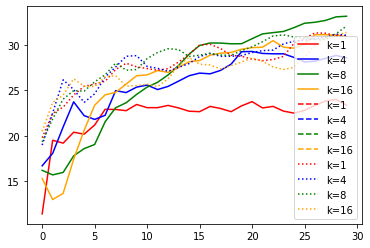

In [54]:
ks= [1, 4, 8, 16]

data = 'cifar10'
model = 'hopfield'
df = pd.read_csv(f'./results/{data}_{model}_heads.csv')
# color scheme by k
colors = ['red', 'blue', 'green', 'orange']
for i, k in enumerate(ks):
    df_k = df[df['k'] == k]
    # take only last 30 rows
    df_k = df_k.iloc[-30:]

    plt.plot(df_k['epoch'], df_k['accuracy'], label=f'k={k}', color=colors[i] )

model = 'hopfieldV'
df = pd.read_csv(f'./results/{data}_{model}_heads.csv')
for i, k in enumerate(ks):
    df_k = df[df['k'] == k]
    # take only last 30 rows
    df_k = df_k.iloc[30:]
    # dash lines
    plt.plot(df_k['epoch'], df_k['accuracy'], label=f'k={k}', linestyle='--', color=colors[i] )


model = 'vit'
df = pd.read_csv(f'./results/{data}_{model}_heads.csv')
for i, k in enumerate(ks):
    df_k = df[df['k'] == k]
    # take only last 30 rows
    df_k = df_k.iloc[-30:]
    # dash lines
    plt.plot(df_k['epoch'], df_k['accuracy'], label=f'k={k}', linestyle=':', color=colors[i] )


plt.legend()

In [14]:
k= 4
df_k = df[df['k'] == k]

In [21]:
# number of rows in df_k
k =4
df_k = df[df['k'] == k]
df_k.shape[0]

150

In [26]:
print(df_k['epoch'].to_numpy())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


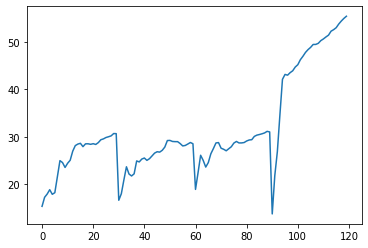

In [49]:
k = 4
df_k = df[df['k'] == k]
plt.plot( df_k['accuracy'].to_numpy(), label=f'k={k}')